In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Leads.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [3]:
# Let's check the missing values percentage in each column

round(100*data.isna().sum()/len(data),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [4]:
# Let's look into the data

data.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [5]:
# Remove the columns with more than 40% missing values

missing_values = data.isnull().sum()
missing_values_percentage = missing_values/len(data)
columns_to_drop = missing_values_percentage[missing_values_percentage > 0.4].index.tolist()
data = data.drop(columns_to_drop, axis=1)
data.shape

(9240, 32)

In [6]:
# Drop the "Prospect ID" and "Lead Number" columns as they serve no purpose in building the model

data = data.drop(["Prospect ID", "Lead Number"], axis=1)
data.shape

(9240, 30)

In [7]:
# Drop the columns that have a low number of "Yes", as they won't affect the model performance.

data = data.drop(["Receive More Updates About Our Courses","Magazine", "Search", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", "Through Recommendations", "Update me on Supply Chain Content", "Do Not Call", "Get updates on DM Content", "I agree to pay the amount through cheque" ], axis=1)
data.shape

(9240, 18)

In [8]:
# Let's look into the data

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9103.000000,9240.000000,9103.000000
mean,0.385390,3.445238,487.698268,2.362820
std,0.486714,4.854853,548.021466,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,12.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,936.000000,3.000000
max,1.000000,251.000000,2272.000000,55.000000


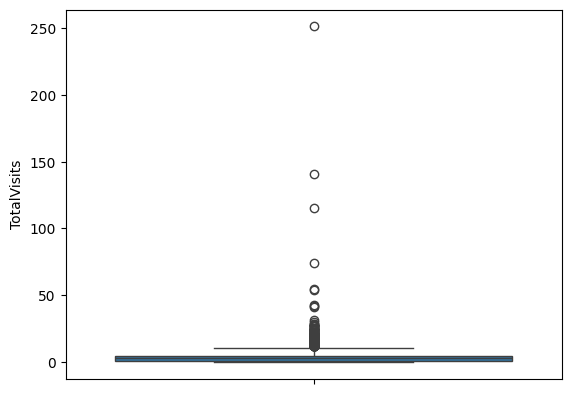

In [9]:
# Let's plot a boxplot for the TotalVisits column

sns.boxplot(data.TotalVisits)
plt.show()

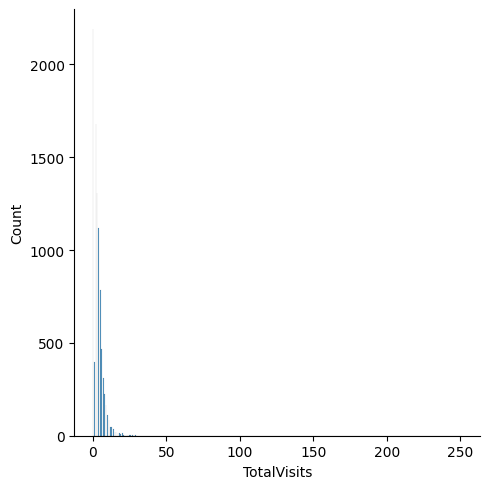

In [10]:
# Plot a histogram for the TotalVisits column

sns.displot(data.TotalVisits)
plt.show()

We can see that there are heavy outliers, skewing the data. Hence these outliers are to be removed.

In [11]:
# Remove the rows that have a high number of Total Visits (> 20), as they skew the entire column data

data = data[~(data.TotalVisits>20)]

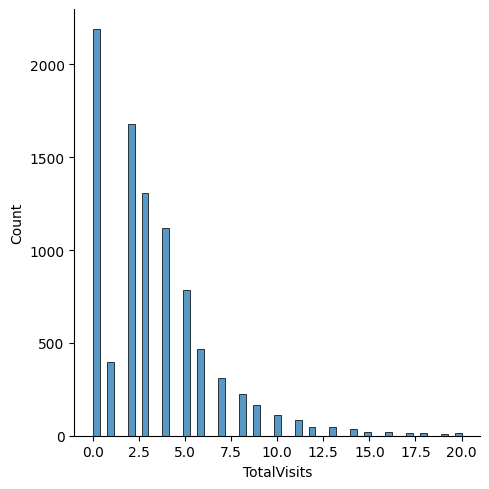

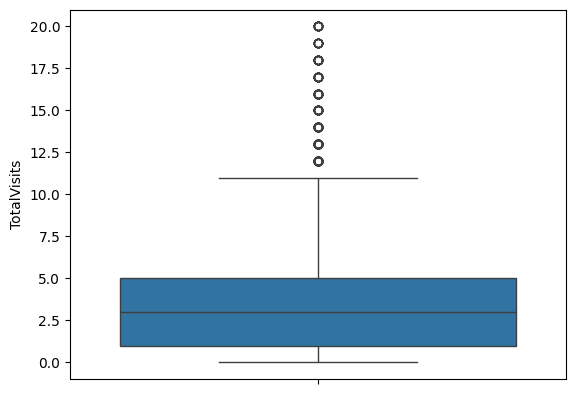

In [12]:
# Let's plot the histogram and boxplot for the TotalVisits column again

sns.displot(data.TotalVisits)
plt.show()
sns.boxplot(data.TotalVisits)
plt.show()

In [13]:
# Let's look into the data description again

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9193.000000,9056.000000,9193.000000,9056.000000
mean,0.385184,3.269435,487.005113,2.342778
std,0.486665,3.144111,547.923193,2.063161
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,11.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,935.000000,3.000000
max,1.000000,20.000000,2272.000000,16.000000


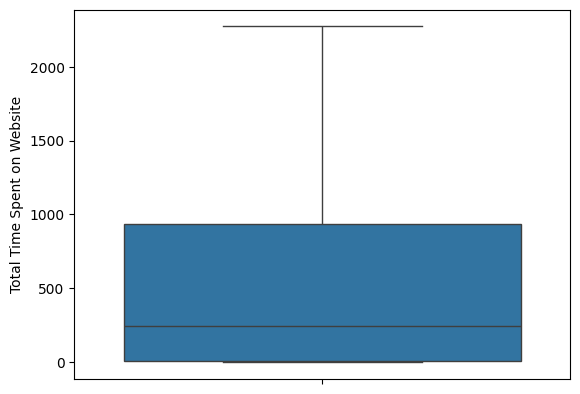

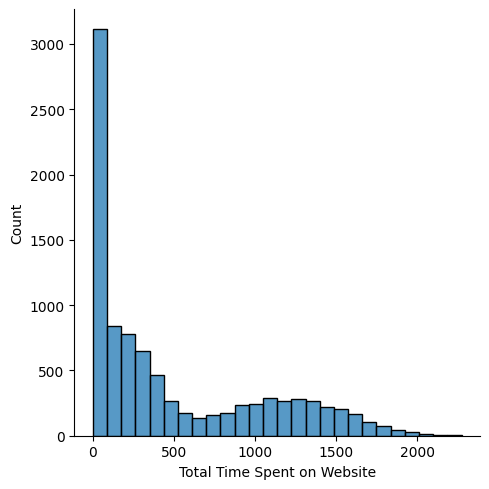

In [14]:
# Let's plot a boxplot and histogram for "Total Time Spent on Website"

sns.boxplot(data["Total Time Spent on Website"])
plt.show()
sns.displot(data["Total Time Spent on Website"])
plt.show()

There are no outliers in the "Total Time Spent on Website" column. But the data is heavily skewed towards the left end.

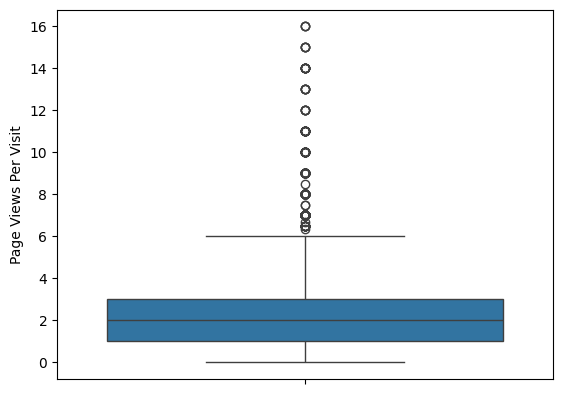

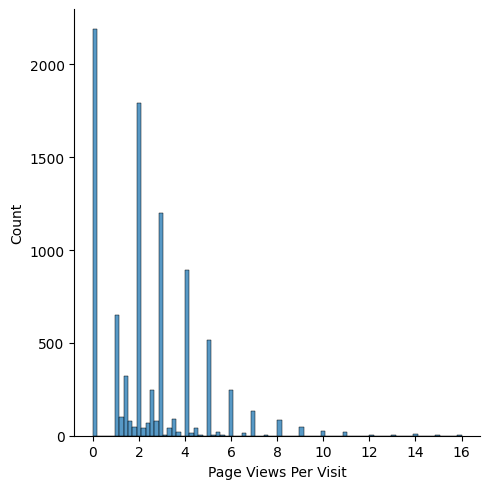

In [15]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column

sns.boxplot(data["Page Views Per Visit"])
plt.show()
sns.displot(data["Page Views Per Visit"])
plt.show()

In [16]:
# Let's remove the outliers from the "Page Views Per Visit" column (> 10 views per visit)

data = data[~(data["Page Views Per Visit"]>10)]

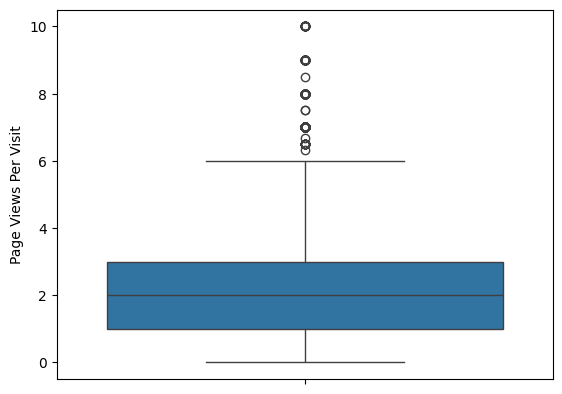

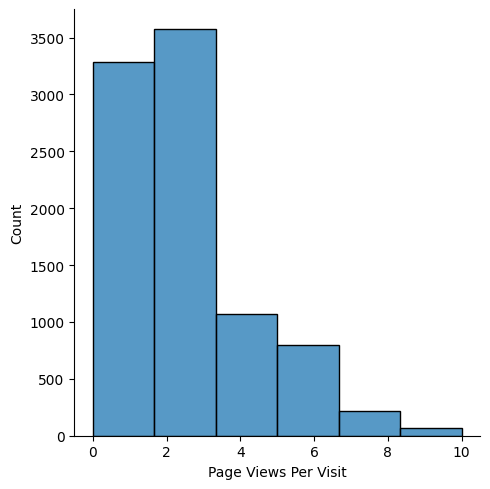

In [17]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column again

sns.boxplot(data["Page Views Per Visit"])
plt.show()
sns.displot(data["Page Views Per Visit"], bins=6)
plt.show()

In [18]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                             36.31
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [19]:
# Let's check the "Tags" column

100*data["Tags"].value_counts(normalize=True)

Tags
Will revert after reading the email                  35.284023
Ringing                                              20.353527
Interested in other courses                           8.752360
Already a student                                     7.945770
Closed by Horizzon                                    6.006521
switched off                                          4.084435
Busy                                                  3.174876
Lost to EINS                                          2.968938
Not doing further education                           2.368286
Interested  in full time MBA                          2.007894
Graduation in progress                                1.887764
invalid number                                        1.424404
Diploma holder (Not Eligible)                         1.081174
wrong number given                                    0.789429
opp hangup                                            0.566329
number not provided                               

Instead of having multiple categories in the Tags columns, we can have all the low significant categories clubbed together as "Others"

In [20]:
# Let's club low significant categories as "Others"
# Let's create a list of required categories

required_categories = data["Tags"].value_counts(normalize=True)[data["Tags"].value_counts(normalize=True) > 0.07].index.tolist()
required_categories

# Let's replace the other categories with "Others" and also impute missing categories as "Others"

data.Tags = data.Tags.fillna("Others")
data["Tags"] = data["Tags"].apply(lambda x: x if x in required_categories else "Others")
100*data["Tags"].value_counts(normalize=True)

Tags
Others                                 53.929391
Will revert after reading the email    22.472401
Ringing                                12.963165
Interested in other courses             5.574380
Already a student                       5.060662
Name: proportion, dtype: float64

In [21]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [22]:
# Let's check the "Lead Profile" column

100*data["Lead Profile"].value_counts(normalize=True)

Lead Profile
Select                         63.501392
Potential Lead                 24.698423
Other Leads                     7.423446
Student of SomeSchool           3.711723
Lateral Student                 0.355707
Dual Specialization Student     0.309310
Name: proportion, dtype: float64

There are some columns that have the value "Select" in it, which are as good as "Null" values, as they might be the default value for missing data/value that is not filled in while inputting the data. Hence we need to identify these columns and impute the values as Null and check the missing values percentage in each column again.

In [23]:
# Let's check the columns that have the value "Select" in them

columns_with_select = [col for col in data.columns if data[col].isin(['Select']).any()]

columns_with_select

['Specialization',
 'How did you hear about X Education',
 'Lead Profile',
 'City']

In [24]:
# Let's impute the "Select" value with Nulls

data[columns_with_select] = data[columns_with_select].replace('Select', np.nan)

In [25]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
City                                             39.95
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [26]:
# Let's check the City column

100*data["City"].value_counts(normalize=True)

City
Mumbai                         57.844922
Thane & Outskirts              13.396432
Other Cities                   12.413542
Other Cities of Maharashtra     8.227157
Other Metro Cities              6.789225
Tier II Cities                  1.328722
Name: proportion, dtype: float64

In [27]:
# Let's check the City column where the Country is not India, Asia/Pacific, unknowns or nulls

data[~(data["Country"].isin(["India", "Asia/Pacific", np.nan, "unknown"]))]["City"].value_counts(normalize=True)

City
Mumbai                         0.407080
Other Cities                   0.296460
Other Cities of Maharashtra    0.101770
Thane & Outskirts              0.092920
Other Metro Cities             0.088496
Tier II Cities                 0.013274
Name: proportion, dtype: float64

The City column is not aligned with the respective country cities and provided with some random data. Hence we can drop the City column. 

In [28]:
# Let's drop the City column

data = data.drop("City", axis=1)
data.shape

(9149, 17)

In [29]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [30]:
# Let's drop the columns "Lead Profile" and "How did you hear about X Education" as they have high number of missing values (> 70%)

data = data.drop(["Lead Profile", "How did you hear about X Education"], axis=1)
data.shape

(9149, 15)

In [31]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [32]:
# Let's check the "Specialization" column

100*data["Specialization"].value_counts(normalize=True)

Specialization
Finance Management                   16.686841
Human Resource Management            14.490749
Marketing Management                 14.352412
Operations Management                 8.663324
Business Administration               6.864949
IT Projects Management                6.259727
Supply Chain Management               5.965762
Banking, Investment And Insurance     5.775549
Media and Advertising                 3.441121
Travel and Tourism                    3.389244
International Business                3.026111
Healthcare Management                 2.697562
Hospitality Management                1.954003
E-COMMERCE                            1.902127
Retail Management                     1.642746
Rural and Agribusiness                1.227736
E-Business                            0.985648
Services Excellence                   0.674390
Name: proportion, dtype: float64

In [33]:
#  Let's create a new column "Specs" where we group different Specialisation values

finance = ['Finance Management', 'Banking, Investment And Insurance','E-COMMERCE','E-Business']
Management = ['Business Administration','Supply Chain Management','IT Projects Management','Human Resource Management','Marketing Management','Operations Management','Retail Management','Hospitality Management','Healthcare Management']
others = ['Media and Advertising','Travel and Tourism','International Business','Services Excellence','Rural and Agribusiness']


data['GroupedSpecialisation'] = data.Specialization.apply(lambda x: 'Finance' if x in finance else('Management' if x in Management else ('Others' if x in others else np.nan)))


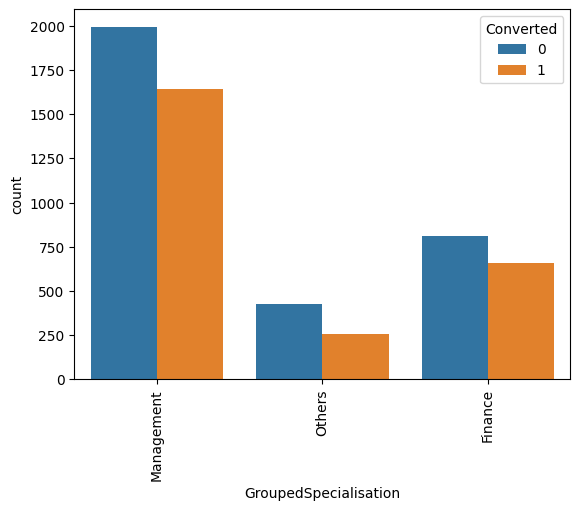

In [34]:
# Let's plot the count for each Specilisation group with respect to Converted column

sns.countplot(x=data['GroupedSpecialisation'],hue=data.Converted).tick_params(axis='x',rotation=90)
plt.show()

In [35]:
# Let's impute the missing values in Specs column with the value "Management"

data.GroupedSpecialisation = data.GroupedSpecialisation.fillna("Management")

# Let's drop the column "Specialization"

data = data.drop("Specialization", axis=1)
data.shape

(9149, 15)

In [36]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
GroupedSpecialisation                             0.00
dtype: float64

In [37]:
# Let's check the 'Country' column

100*data["Country"].value_counts(normalize=True)

Country
India                   95.738636
United States            1.016746
United Arab Emirates     0.792464
Singapore                0.358852
Saudi Arabia             0.313995
United Kingdom           0.224282
Australia                0.194378
Qatar                    0.149522
Hong Kong                0.104665
Bahrain                  0.104665
France                   0.089713
Oman                     0.089713
Germany                  0.059809
unknown                  0.059809
South Africa             0.059809
Nigeria                  0.059809
Kuwait                   0.059809
Canada                   0.059809
Sweden                   0.044856
China                    0.029904
Asia/Pacific Region      0.029904
Uganda                   0.029904
Bangladesh               0.029904
Italy                    0.029904
Belgium                  0.029904
Netherlands              0.029904
Ghana                    0.029904
Philippines              0.029904
Russia                   0.014952
Switze

In [38]:
# Since the majority of the Country values are "India", let's group the other countries together with "International" and impute missing values with "India"

data['Country'] = data.Country.fillna('India')
data['Country'] = data.Country.apply(lambda x: 'India' if x == 'India' else 'International')

In [39]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                           0.00
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
GroupedSpecialisation                             0.00
dtype: float64

In [40]:
# Let's rename the column "What is your current occupation" to "Occupation"

data.rename(columns={"What is your current occupation": "Occupation"}, inplace=True)

In [41]:
# Let's check the "Occupation" column

100*data["Occupation"].value_counts(normalize=True)

Occupation
Unemployed              85.456508
Working Professional    10.826650
Student                  3.223319
Other                    0.231339
Housewife                0.154226
Businessman              0.107958
Name: proportion, dtype: float64

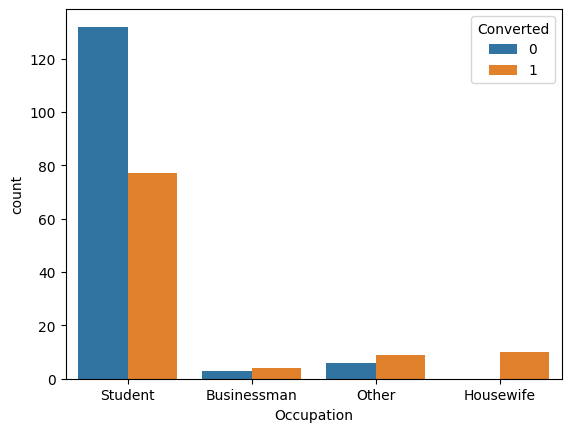

In [42]:
filtered_values = ["Student", "Housewife", "Other", "Businessman"]

filtered_data = data[data["Occupation"].isin(filtered_values)]


sns.countplot(x="Occupation", hue="Converted", data=filtered_data)
plt.show()

In [45]:
conversion_percentage = data.groupby('Occupation')['Converted'].value_counts(normalize=True).unstack() * 100
conversion_percentage = conversion_percentage.reset_index()


In [46]:
conversion_percentage

Converted,Occupation,0,1
0,Businessman,42.857143,57.142857
1,Housewife,NaN,100.000000
2,Other,40.000000,60.000000
3,Student,63.157895,36.842105
4,Unemployed,56.361668,43.638332
5,Working Professional,8.404558,91.595442
